In [24]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata

In [ ]:
optimal_params = [5.51528540e+02, -9.20083075e+02, 1.07015743e-01, 9.79484642e-01]

In [ ]:
def transform_coords(params, x, y):
    tx, ty, theta, scale = params
    
    # Apply transformation
    x_new = scale * (x * np.cos(theta) - y * np.sin(theta)) + tx
    y_new = scale * (x * np.sin(theta) + y * np.cos(theta)) + ty
    
    return x_new, y_new

In [ ]:
def map_cells_dataframe(dfC1, dfC2, optimal_params):
    """Create aligned cell dataframes"""
    # Make copies to avoid modifying originals
    dfC1_final = dfC1.copy()
    dfC2_final = dfC2.copy()
    
    dfC1_final['dataset'] = 'dataset1'
    dfC2_final['dataset'] = 'dataset2'
    
    x_aligned, y_aligned = transform_coords(
        optimal_params,
        dfC2_final['x_centroid'].values,
        dfC2_final['y_centroid'].values
    )
    
    dfC2_final['x_centroid_aligned'] = x_aligned
    dfC2_final['y_centroid_aligned'] = y_aligned
    
    dfC1_final['x_centroid_aligned'] = dfC1_final['x_centroid']
    dfC1_final['y_centroid_aligned'] = dfC1_final['y_centroid']
    
    cell_mapping = pd.DataFrame({
        'cell_id': dfC2_final['cell_id'],
        'x_orig': dfC2_final['x_centroid'],
        'y_orig': dfC2_final['y_centroid'],
        'x_aligned': dfC2_final['x_centroid_aligned'],
        'y_aligned': dfC2_final['y_centroid_aligned']
    })
    
    return dfC1_final, dfC2_final, cell_mapping

In [ ]:
def map_transcripts_dataframe(dfT1, dfT2, optimal_params, cell_mapping=None):
    """Create aligned transcript dataframes"""
    dfT1_final = dfT1.copy()
    dfT2_final = dfT2.copy()
    
    dfT1_final['dataset'] = 'dataset1'
    dfT2_final['dataset'] = 'dataset2'
    
    x_aligned, y_aligned = transform_coords(
        optimal_params,
        dfT2_final['x_location'].values,
        dfT2_final['y_location'].values
    )
    
    dfT2_final['x_location_aligned'] = x_aligned
    dfT2_final['y_location_aligned'] = y_aligned
    
    dfT1_final['x_location_aligned'] = dfT1_final['x_location']
    dfT1_final['y_location_aligned'] = dfT1_final['y_location']
    
    return dfT1_final, dfT2_final

In [ ]:
def create_aligned_anndata(adata1, adata2, dfC1_final, dfC2_final, optimal_params):
    """Create aligned AnnData objects with spatial information"""
    
    adata1_aligned = adata1.copy()
    adata2_aligned = adata2.copy()
    
    x1_coords = dfC1_final.set_index('cell_id').loc[adata1_aligned.obs_names, 'x_centroid'].values
    y1_coords = dfC1_final.set_index('cell_id').loc[adata1_aligned.obs_names, 'y_centroid'].values
    
    adata1_aligned.obsm['spatial'] = np.column_stack((x1_coords, y1_coords))
    
    x2_orig = dfC2_final.set_index('cell_id').loc[adata2_aligned.obs_names, 'x_centroid'].values
    y2_orig = dfC2_final.set_index('cell_id').loc[adata2_aligned.obs_names, 'y_centroid'].values
    
    x2_aligned, y2_aligned = transform_coords(optimal_params, x2_orig, y2_orig)
    
    adata2_aligned.obsm['spatial_original'] = np.column_stack((x2_orig, y2_orig))
    
    adata2_aligned.obsm['spatial'] = np.column_stack((x2_aligned, y2_aligned))
    
    adata1_aligned.obs['batch'] = 'batch1'
    adata2_aligned.obs['batch'] = 'batch2'
    
    return adata1_aligned, adata2_aligned

In [ ]:
def create_combined_dataset(adata1_aligned, adata2_aligned):
    """Create a combined dataset with common genes between both datasets"""
    
    common_genes = list(set(adata1_aligned.var_names).intersection(set(adata2_aligned.var_names)))
    print(f"Number of common genes: {len(common_genes)}")
    
    adata1_common = adata1_aligned[:, common_genes].copy()
    adata2_common = adata2_aligned[:, common_genes].copy()
    
    combined = anndata.concat([adata1_common, adata2_common], join='inner')
    
    return combined

In [ ]:
# Save final datasets for VAE training
def save_final_datasets(dfC1_final, dfC2_final, dfT1_final, dfT2_final, 
                       adata1_aligned, adata2_aligned, combined):
    """Save all final datasets for VAE training"""
    
    # Save cell dataframes
    dfC1_final.to_parquet('cells1_aligned.parquet')
    dfC2_final.to_parquet('cells2_aligned.parquet')
    
    # Save transcript dataframes
    dfT1_final.to_parquet('transcripts1_aligned.parquet')
    dfT2_final.to_parquet('transcripts2_aligned.parquet')
    
    # Save AnnData objects
    adata1_aligned.write('adata1_aligned.h5ad')
    adata2_aligned.write('adata2_aligned.h5ad')
    combined.write('combined_aligned.h5ad')
    
    print("All datasets saved successfully!")

#  Visualize final mapped datasets
def visualize_final_mapping(adata1_aligned, adata2_aligned):
    """Visualize the final mapping between datasets"""
    
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
    
    # Dataset 1 (original coordinates)
    sc.pl.embedding(adata1_aligned, basis='spatial', color='batch', 
                   size=10, title='Dataset 1 (Reference)', show=False, ax=ax[0])
    
    # Dataset 2 (aligned coordinates)
    sc.pl.embedding(adata2_aligned, basis='spatial', color='batch', 
                   size=10, title='Dataset 2 (Aligned)', show=False, ax=ax[1])
    
    # Combined view
    coords1 = adata1_aligned.obsm['spatial']
    coords2 = adata2_aligned.obsm['spatial']
    
    ax[2].scatter(coords1[:, 0], coords1[:, 1], s=10, alpha=0.5, c='blue', label='Dataset 1')
    ax[2].scatter(coords2[:, 0], coords2[:, 1], s=10, alpha=0.5, c='red', label='Dataset 2 (Aligned)')
    ax[2].set_title('Overlay of Both Datasets')
    ax[2].legend()
    
    plt.tight_layout()
    plt.savefig('final_mapping_visualization.png', dpi=300)
    plt.show()

In [32]:
adata1 = sc.read_10x_h5("cell_feature_matrix.h5")
adata2 = sc.read_10x_h5("cell_feature_matrix2.h5")

In [33]:
dfC1 = pd.read_parquet("cells.parquet")
dfC2 = pd.read_parquet("cells2.parquet")

In [34]:
dfT1 = pd.read_parquet("transcripts.parquet")
dfT2 = pd.read_parquet("transcripts2.parquet")

Number of common genes: 196


/scratch/work/sagara22/data-pre/.sqvenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


All datasets saved successfully!


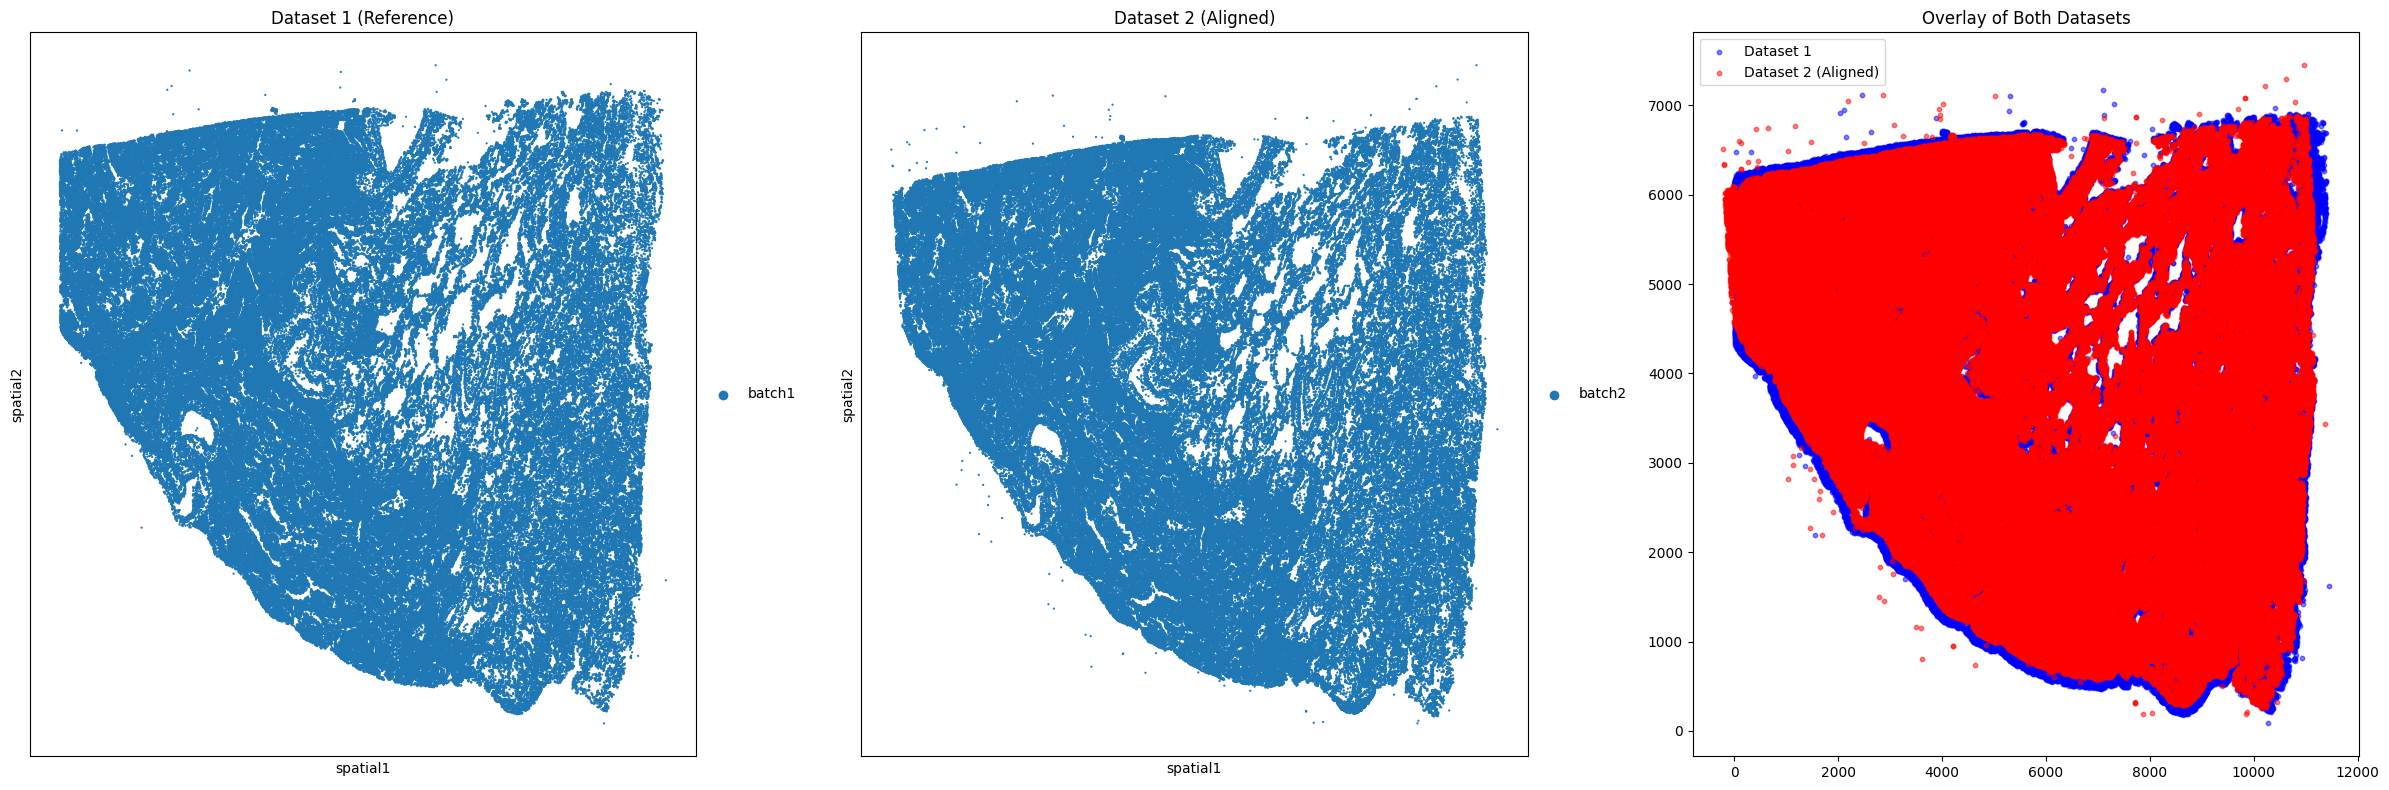

In [35]:
dfC1_final, dfC2_final, cell_mapping = map_cells_dataframe(dfC1, dfC2, optimal_params)
dfT1_final, dfT2_final = map_transcripts_dataframe(dfT1, dfT2, optimal_params, cell_mapping)
adata1_aligned, adata2_aligned = create_aligned_anndata(adata1, adata2, dfC1_final, dfC2_final, optimal_params)
combined = create_combined_dataset(adata1_aligned, adata2_aligned)
save_final_datasets(dfC1_final, dfC2_final, dfT1_final, dfT2_final, adata1_aligned, adata2_aligned, combined)
visualize_final_mapping(adata1_aligned, adata2_aligned)

In [36]:
!pwd

/scratch/work/sagara22/data-pre


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import anndata

In [ ]:
class SpatialTranscriptomicsVAE(nn.Module):
    def __init__(self, input_dim1, input_dim2, latent_dim=64, 
                 spatial_dim=32, hidden_dims=[512, 256, 128]):
        super(SpatialTranscriptomicsVAE, self).__init__()
        
        # Dimensions
        self.input_dim1 = input_dim1  # Gene counts dim for dataset 1
        self.input_dim2 = input_dim2  # Gene counts dim for dataset 2
        self.latent_dim = latent_dim  # Shared latent space dimension
        self.spatial_dim = spatial_dim  # Spatial embedding dimension
        self.hidden_dims = hidden_dims
        
        # Encoder for dataset 1
        encoder_layers1 = []
        current_dim = input_dim1 + 2  # +2 for spatial coordinates
        
        for h_dim in hidden_dims:
            encoder_layers1.append(nn.Linear(current_dim, h_dim))
            encoder_layers1.append(nn.BatchNorm1d(h_dim))
            encoder_layers1.append(nn.LeakyReLU())
            current_dim = h_dim
            
        self.encoder1 = nn.Sequential(*encoder_layers1)
        self.mean1 = nn.Linear(hidden_dims[-1], latent_dim)
        self.var1 = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Encoder for dataset 2
        encoder_layers2 = []
        current_dim = input_dim2 + 2  # +2 for spatial coordinates
        
        for h_dim in hidden_dims:
            encoder_layers2.append(nn.Linear(current_dim, h_dim))
            encoder_layers2.append(nn.BatchNorm1d(h_dim))
            encoder_layers2.append(nn.LeakyReLU())
            current_dim = h_dim
            
        self.encoder2 = nn.Sequential(*encoder_layers2)
        self.mean2 = nn.Linear(hidden_dims[-1], latent_dim)
        self.var2 = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder for dataset 1
        decoder_layers1 = []
        current_dim = latent_dim + 2  # +2 for spatial coordinates
        
        for h_dim in reversed(hidden_dims):
            decoder_layers1.append(nn.Linear(current_dim, h_dim))
            decoder_layers1.append(nn.BatchNorm1d(h_dim))
            decoder_layers1.append(nn.LeakyReLU())
            current_dim = h_dim
            
        self.decoder1 = nn.Sequential(*decoder_layers1)
        self.output1 = nn.Linear(hidden_dims[0], input_dim1)
        
        # Decoder for dataset 2
        decoder_layers2 = []
        current_dim = latent_dim + 2  # +2 for spatial coordinates
        
        for h_dim in reversed(hidden_dims):
            decoder_layers2.append(nn.Linear(current_dim, h_dim))
            decoder_layers2.append(nn.BatchNorm1d(h_dim))
            decoder_layers2.append(nn.LeakyReLU())
            current_dim = h_dim
            
        self.decoder2 = nn.Sequential(*decoder_layers2)
        self.output2 = nn.Linear(hidden_dims[0], input_dim2)
        
        # Spatial transformation network (dataset 1 to dataset 2)
        self.spatial_transform = nn.Sequential(
            nn.Linear(2, spatial_dim),
            nn.LeakyReLU(),
            nn.Linear(spatial_dim, spatial_dim),
            nn.LeakyReLU(),
            nn.Linear(spatial_dim, 2)
        )
    
    def encode1(self, x, coords):
        # Concatenate gene expression with spatial coordinates
        x_combined = torch.cat([x, coords], dim=1)
        h = self.encoder1(x_combined)
        z_mean = self.mean1(h)
        z_var = self.var1(h)
        return z_mean, z_var
    
    def encode2(self, x, coords):
        # Concatenate gene expression with spatial coordinates
        x_combined = torch.cat([x, coords], dim=1)
        h = self.encoder2(x_combined)
        z_mean = self.mean2(h)
        z_var = self.var2(h)
        return z_mean, z_var
    
    def reparameterize(self, mean, var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
    
    def decode1(self, z, coords):
        # Concatenate latent vector with spatial coordinates
        z_combined = torch.cat([z, coords], dim=1)
        h = self.decoder1(z_combined)
        return self.output1(h)
    
    def decode2(self, z, coords):
        # Concatenate latent vector with spatial coordinates
        z_combined = torch.cat([z, coords], dim=1)
        h = self.decoder2(z_combined)
        return self.output2(h)
    
    def transform_coords(self, coords):
        # Transform coordinates from domain 1 to domain 2
        return self.spatial_transform(coords)
    
    def forward(self, x1=None, coords1=None, x2=None, coords2=None, mode='both'):
        """
        Forward pass with flexible mode options:
        - 'both': Train with both datasets (normal training)
        - '1to2': Encode from dataset 1, decode to dataset 2
        - '2to1': Encode from dataset 2, decode to dataset 1
        """
        results = {}
        
        if mode in ['both', '1to2']:
            # Encode dataset 1
            mean1, var1 = self.encode1(x1, coords1)
            z1 = self.reparameterize(mean1, var1)
            
            # Decode to dataset 1 (reconstruction)
            x1_recon = self.decode1(z1, coords1)
            
            # Transform coordinates from domain 1 to domain 2
            coords1_transformed = self.transform_coords(coords1)
            
            # Decode to dataset 2 (translation)
            x2_from_1 = self.decode2(z1, coords1_transformed)
            
            results.update({
                'mean1': mean1, 
                'var1': var1, 
                'z1': z1,
                'x1_recon': x1_recon,
                'coords1_transformed': coords1_transformed,
                'x2_from_1': x2_from_1
            })
        
        if mode in ['both', '2to1']:
            # Encode dataset 2
            mean2, var2 = self.encode2(x2, coords2)
            z2 = self.reparameterize(mean2, var2)
            
            # Decode to dataset 2 (reconstruction)
            x2_recon = self.decode2(z2, coords2)
            
            # Need to add inverse transform for completeness
            # This would transform coordinates from domain 2 to domain 1
            # For simplicity, a heuristic based on the forward transform
            
            results.update({
                'mean2': mean2, 
                'var2': var2, 
                'z2': z2,
                'x2_recon': x2_recon
            })
            
        return results

In [39]:
# Loss function
class SpatialVAELoss(nn.Module):
    def __init__(self, kl_weight=0.1, cycle_weight=1.0, coord_weight=0.5):
        super(SpatialVAELoss, self).__init__()
        self.kl_weight = kl_weight
        self.cycle_weight = cycle_weight
        self.coord_weight = coord_weight
        
    def forward(self, outputs, x1=None, x2=None, coords1=None, coords2=None, mode='both'):
        loss = 0
        
        # Reconstruction loss for domain 1
        if mode in ['both', '1to2'] and x1 is not None:
            recon_loss1 = F.mse_loss(outputs['x1_recon'], x1)
            loss += recon_loss1
            
            # KL divergence for domain 1
            kl_loss1 = -0.5 * torch.sum(1 + outputs['var1'] - outputs['mean1'].pow(2) - outputs['var1'].exp())
            loss += self.kl_weight * kl_loss1
        
        # Reconstruction loss for domain 2
        if mode in ['both', '2to1'] and x2 is not None:
            recon_loss2 = F.mse_loss(outputs['x2_recon'], x2)
            loss += recon_loss2
            
            # KL divergence for domain 2
            kl_loss2 = -0.5 * torch.sum(1 + outputs['var2'] - outputs['mean2'].pow(2) - outputs['var2'].exp())
            loss += self.kl_weight * kl_loss2
        
        # Cycle consistency loss (optional)
        if mode == 'both' and 'x2_from_1' in outputs:
            # This would require encoding x2_from_1 back to z and decoding to x1 again
            # For simplicity, we'll skip this for now
            pass
        
        # Coordinate transformation regularization
        if mode in ['both', '1to2'] and 'coords1_transformed' in outputs:
            # Regularize the coordinate transformation to be smooth
            # This is a simplified version - in practice, you might want something more sophisticated
            coord_diff = torch.diff(outputs['coords1_transformed'], dim=0)
            smoothness_loss = torch.mean(torch.sum(coord_diff**2, dim=1))
            loss += self.coord_weight * smoothness_loss
            
        return loss


In [40]:
# Training function
def train_spatial_vae(model, dataloader, optimizer, criterion, device, 
                     num_epochs=100, log_interval=10):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        
        for batch_idx, (x1, coords1, x2, coords2) in enumerate(dataloader):
            x1, coords1 = x1.to(device), coords1.to(device)
            x2, coords2 = x2.to(device), coords2.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x1=x1, coords1=coords1, x2=x2, coords2=coords2, mode='both')
            
            # Compute loss
            loss = criterion(outputs, x1=x1, x2=x2, coords1=coords1, coords2=coords2, mode='both')
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        # Log progress
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        if (epoch + 1) % log_interval == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
    
    return losses

In [41]:
# Test function to evaluate model and visualize results
def test_spatial_vae(model, adata1, adata2, device, n_samples=1000):
    model.eval()
    
    # Sample cells from dataset 1
    indices1 = np.random.choice(adata1.shape[0], size=n_samples, replace=False)
    x1 = torch.tensor(adata1.X[indices1].toarray(), dtype=torch.float32).to(device)
    coords1 = torch.tensor(adata1.obsm['spatial'][indices1], dtype=torch.float32).to(device)
    
    # Use model to translate from dataset 1 to dataset 2
    with torch.no_grad():
        outputs = model(x1=x1, coords1=coords1, mode='1to2')
        
    # Get transformed coordinates and gene expression predictions
    coords1_transformed = outputs['coords1_transformed'].cpu().numpy()
    x2_from_1 = outputs['x2_from_1'].cpu().numpy()
    
    # Visualize original and transformed coordinates
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original dataset 1 coordinates
    ax[0].scatter(adata1.obsm['spatial'][:, 0], adata1.obsm['spatial'][:, 1], 
                 s=1, alpha=0.2, c='blue', label='Dataset 1 (All)')
    ax[0].scatter(coords1.cpu().numpy()[:, 0], coords1.cpu().numpy()[:, 1], 
                 s=3, alpha=0.5, c='darkblue', label='Dataset 1 (Sampled)')
    ax[0].set_title('Original Dataset 1')
    ax[0].legend()
    
    # Transformed coordinates
    ax[1].scatter(adata2.obsm['spatial'][:, 0], adata2.obsm['spatial'][:, 1], 
                 s=1, alpha=0.2, c='red', label='Dataset 2 (All)')
    ax[1].scatter(coords1_transformed[:, 0], coords1_transformed[:, 1], 
                 s=3, alpha=0.5, c='darkred', label='Dataset 1→2 (Transformed)')
    ax[1].set_title('Dataset 1 Transformed to Dataset 2 Space')
    ax[1].legend()
    
    # Overlay of real and transformed
    ax[2].scatter(adata2.obsm['spatial'][:, 0], adata2.obsm['spatial'][:, 1], 
                 s=1, alpha=0.2, c='red', label='Dataset 2 (Real)')
    ax[2].scatter(coords1_transformed[:, 0], coords1_transformed[:, 1], 
                 s=3, alpha=0.5, c='darkblue', label='Dataset 1→2 (Transformed)')
    ax[2].set_title('Overlay: Real vs. Transformed')
    ax[2].legend()
    
    plt.tight_layout()
    plt.savefig('vae_transformation_results.png', dpi=300)
    plt.show()
    
    return coords1_transformed, x2_from_1


In [42]:
# Data preparation function
def prepare_data_for_vae(adata1_aligned, adata2_aligned, batch_size=128, test_size=0.1):
    """Prepare data for VAE training"""
    
    # Extract gene expression and spatial coordinates
    X1 = adata1_aligned.X.toarray() if isinstance(adata1_aligned.X, np.ndarray) else adata1_aligned.X.toarray()
    coords1 = adata1_aligned.obsm['spatial']
    
    X2 = adata2_aligned.X.toarray() if isinstance(adata2_aligned.X, np.ndarray) else adata2_aligned.X.toarray()
    coords2 = adata2_aligned.obsm['spatial']
    
    # Normalize gene expression data
    scaler1 = StandardScaler()
    X1_scaled = scaler1.fit_transform(X1)
    
    scaler2 = StandardScaler()
    X2_scaled = scaler2.fit_transform(X2)
    
    # Convert to PyTorch tensors
    X1_tensor = torch.tensor(X1_scaled, dtype=torch.float32)
    coords1_tensor = torch.tensor(coords1, dtype=torch.float32)
    
    X2_tensor = torch.tensor(X2_scaled, dtype=torch.float32)
    coords2_tensor = torch.tensor(coords2, dtype=torch.float32)
    
    # Create dataset and dataloader
    dataset = TensorDataset(X1_tensor, coords1_tensor, X2_tensor, coords2_tensor)
    
    # Split into train and test
    train_size = int((1 - test_size) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, (scaler1, scaler2)

In [43]:
# Main function to run everything
def run_spatial_vae(adata1_aligned, adata2_aligned, 
                   latent_dim=64, 
                   spatial_dim=32, 
                   hidden_dims=[512, 256, 128],
                   batch_size=128,
                   num_epochs=100,
                   learning_rate=1e-4,
                   kl_weight=0.1,
                   cycle_weight=1.0,
                   coord_weight=0.5):
    """Run the entire VAE pipeline"""
    
    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Prepare data
    train_loader, test_loader, (scaler1, scaler2) = prepare_data_for_vae(
        adata1_aligned, adata2_aligned, batch_size=batch_size
    )
    
    # Create model
    input_dim1 = adata1_aligned.n_vars
    input_dim2 = adata2_aligned.n_vars
    
    model = SpatialTranscriptomicsVAE(
        input_dim1=input_dim1,
        input_dim2=input_dim2,
        latent_dim=latent_dim,
        spatial_dim=spatial_dim,
        hidden_dims=hidden_dims
    ).to(device)
    
    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create loss function
    criterion = SpatialVAELoss(
        kl_weight=kl_weight,
        cycle_weight=cycle_weight,
        coord_weight=coord_weight
    )
    
    # Train model
    losses = train_spatial_vae(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs
    )
    
    # Visualize training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('vae_training_loss.png')
    plt.show()
    
    # Test model
    coords1_transformed, x2_from_1 = test_spatial_vae(
        model=model,
        adata1=adata1_aligned,
        adata2=adata2_aligned,
        device=device
    )
    
    # Save model
    torch.save(model.state_dict(), 'spatial_vae_model.pt')
    
    return model, coords1_transformed, x2_from_1

In [44]:

# Load aligned data
adata1_aligned = sc.read_h5ad('adata1_aligned.h5ad')
adata2_aligned = sc.read_h5ad('adata2_aligned.h5ad')

# Run VAE
model, coords1_transformed, x2_from_1 = run_spatial_vae(
    adata1_aligned=adata1_aligned,
    adata2_aligned=adata2_aligned,
    num_epochs=100
)

Using device: cuda


AssertionError: Size mismatch between tensors